# Challenge

Write a scraper that will:

- Return specific pieces of information (rather than just downloading a whole page)
- Iterate over multiple pages/queries
- Save the data to your computer

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest. Write up a report from scraping code to summary.

Original link: http://publicpay.ca.gov/Reports/RawExport.aspx

Suggested from scraping task examples: https://github.com/stanfordjournalism/search-script-scrape#the-tasks

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess

import json
from pprint import pprint

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import matplotlib.pyplot as plt
import operator

I have chosen a dataset involving compensation of government workers in California. I will use scrapy to crawl the page of available downloads from each year and selectively download all government payout spreadsheets from the year 2010 for cost analysis.

Create the spider, define source URL and search criteria based on information gathered from "Inspect" function on webpage.

In [1]:
class CaliforniaWagesSpider(scrapy.Spider):
    name = "CaliforniaWages"

    start_urls = [
        'http://publicpay.ca.gov/Reports/RawExport.aspx',
    ]
    
    def parse(self, response):
        for link in response.xpath("//a[starts-with(@href, '/RawExport/2010')]"):
            yield {'url': link.xpath('@href').extract_first()}

process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'california_wage_links.json',
    'LOG_ENABLED': False           # Turn off logging.
})

process.crawl(CaliforniaWagesSpider)
process.start()
print('Success!')

:0: UserWarning: You do not have a working installation of the service_identity module: 'cannot import name 'opentype''.  Please install it from <https://pypi.python.org/pypi/service_identity> and make sure all of its dependencies are satisfied.  Without the service_identity module, Twisted can perform only rudimentary TLS client hostname verification.  Many valid certificate/hostname mappings may be rejected.


Success!


Confirm that URLs have been exported to json file in local directory.

In [8]:
with open('california_wage_links.json') as data_file:
    cali_wage_json = json.load(data_file)
pprint(cali_wage_json)

[{'url': '/RawExport/2010_CaliforniaStateUniversity.zip'},
 {'url': '/RawExport/2010_City.zip'},
 {'url': '/RawExport/2010_County.zip'},
 {'url': '/RawExport/2010_SpecialDistrict.zip'},
 {'url': '/RawExport/2010_StateDepartment.zip'}]


Extract only the URLs from the json output file.

In [68]:
url_list = []
for dict in cali_wage_json:
    url_list.append(dict['url'])

full_url_list = ['http://publicpay.ca.gov/' + url for url in url_list] 
print(full_url_list)

['http://publicpay.ca.gov//RawExport/2010_CaliforniaStateUniversity.zip', 'http://publicpay.ca.gov//RawExport/2010_City.zip', 'http://publicpay.ca.gov//RawExport/2010_County.zip', 'http://publicpay.ca.gov//RawExport/2010_SpecialDistrict.zip', 'http://publicpay.ca.gov//RawExport/2010_StateDepartment.zip']


Iterate through all the URLs and use ZipFile to extract zipped CSVs.

In [70]:
wages_df = pd.DataFrame()

for zipurl in full_url_list:
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('/Users/Leah/AnacondaProjects/Unit 5: Other Topics in Data Science')
            for filename in zfile.namelist():
                temp_df = pd.read_csv(filename, encoding='latin_1')
                print(temp_df.shape)
                wages_df = wages_df.append(temp_df,ignore_index=True)
            
print(wages_df.head())

(95963, 28)
(316626, 28)
(374773, 28)
(160388, 28)
(253634, 28)
   Year                  Entity Type      Entity Group          Entity Name  \
0  2010  California State University  Higher Education  Chancellor's Office   
1  2010  California State University  Higher Education  Chancellor's Office   
2  2010  California State University  Higher Education  Chancellor's Office   
3  2010  California State University  Higher Education  Chancellor's Office   
4  2010  California State University  Higher Education  Chancellor's Office   

  Department / Subdivision               Position  Elected Official  Judicial  \
0                      NaN  Accountant I, Range 1               NaN       NaN   
1                      NaN  Accountant I, Range 1               NaN       NaN   
2                      NaN  Accountant I, Range 1               NaN       NaN   
3                      NaN  Accountant I, Range 1               NaN       NaN   
4                      NaN  Accountant I, Range 1       

Let's take a look at how much data there is and what information is available to us.

In [73]:
print(wages_df.shape)
print(wages_df.columns)

(1201384, 28)
Index(['Year', 'Entity Type', 'Entity Group', 'Entity Name',
       'Department / Subdivision', 'Position', 'Elected Official', 'Judicial',
       'Other Positions', 'Min Position Salary', 'Max Position Salary',
       'Reported Base Wage', 'Regular Pay', 'Overtime Pay', 'Lump-Sum Pay',
       'Other Pay', 'Total Wages', 'Defined Benefit Plan Contribution',
       'Employees Retirement Cost Covered', 'Deferred Compensation Plan',
       'Health Dental Vision', 'Total Retirement and Health Cost',
       'Pension Formula', 'Entity URL', 'Entity Population', 'Last Updated',
       'Entity County', 'Special District Activities'],
      dtype='object')


I would like to see how much money is spent on salaries, as well as a benefits such as healthcare and retirement savings. I will create a histogram for each category and print out the maximum and minimum for each category.

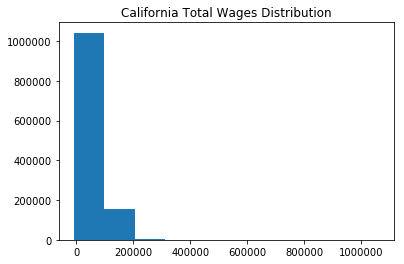

Minimum Total Wages: -8460.05
Maximum Total Wages: 1059529.0


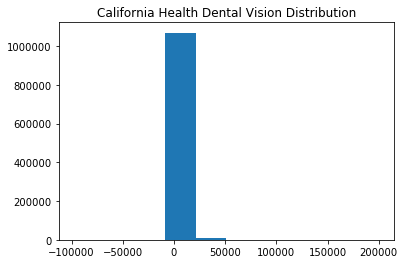

Minimum Health Dental Vision: -97569.55
Maximum Health Dental Vision: 199628.0


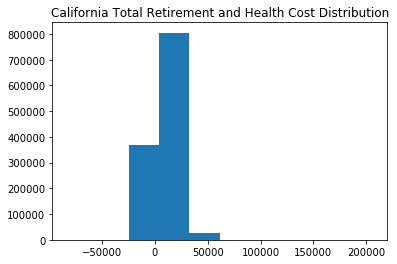

Minimum Total Retirement and Health Cost: -82517.15
Maximum Total Retirement and Health Cost: 205507.0


In [94]:
topics_of_interest = ['Total Wages','Health Dental Vision','Total Retirement and Health Cost']

for topic in topics_of_interest:
    column = wages_df[topic].dropna()
    plt.hist(column)
    plt.title(f'California {topic} Distribution')
    plt.show()
    
    print(f'Minimum {topic}: {column.min()}')
    print(f'Maximum {topic}: {column.max()}')

Interesting...the minimum for each category is an extreme negative value. What could this suggest? It could be a clerical error, or it could signify payment from the employee. Let's investigate the prevalence of these negative values.

In [143]:
print(wages_df.loc[wages_df['Total Wages'] < 0].shape)
print(wages_df.loc[wages_df['Health Dental Vision'] < 0].shape)
print(wages_df.loc[wages_df['Total Retirement and Health Cost'] < 0].shape)

(3, 28)
(437, 28)
(385, 28)


There are far too many negative values in 'Health Dental Vision' and 'Total Retirement and Health Cost' to attribute this to a clerical error. In a professional scenario, I would reach out to the author of this data to understand where the negative values are coming from. However, in the interest of time I will skip this and instead drop all rows where negative values are observed.

In [149]:
wages_df_positive = wages_df.loc[wages_df['Total Wages'] > 0]
wages_df_positive = wages_df_positive.loc[wages_df_positive['Health Dental Vision'] > 0]
wages_df_positive = wages_df_positive.loc[wages_df_positive['Total Retirement and Health Cost'] > 0]

print(wages_df.shape)
print(wages_df_positive.shape)

(1201384, 28)
(881102, 28)


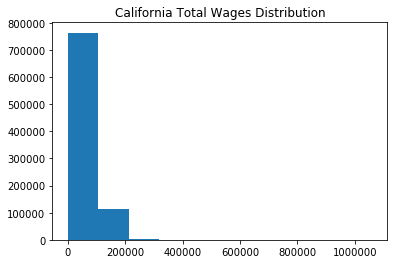

Minimum Total Wages: 1.0
Maximum Total Wages: 1059529.0


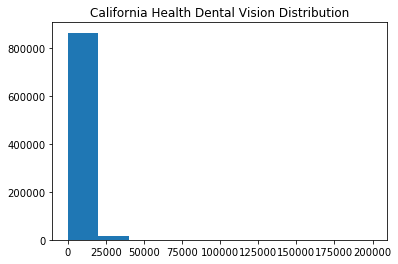

Minimum Health Dental Vision: 0.95
Maximum Health Dental Vision: 199628.0


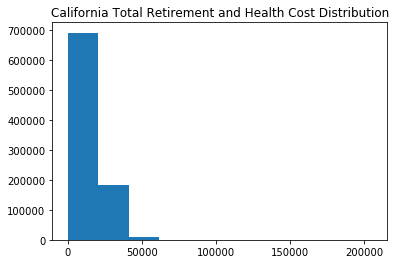

Minimum Total Retirement and Health Cost: 1.0
Maximum Total Retirement and Health Cost: 205507.0


In [150]:
for topic in topics_of_interest:
    column = wages_df_positive[topic].dropna()
    plt.hist(column)
    plt.title(f'California {topic} Distribution')
    plt.show()
    
    print(f'Minimum {topic}: {column.min()}')
    print(f'Maximum {topic}: {column.max()}')

Setting a minimum on our data above 0 does not really help because we are still seeing wages at less than a dollar, which is not a reasonable number. While this will not affect the maximum, it will skew the average. In this situation, I would reach out to the author of the data for clarity. <br>

Continuing with our analysis, we can see that there is not a wide distribution in costs. The vast majority of people fall within the first bin, with fractionally small workers populating the upper bins. This means there is a large disparity betweent the top-earning workers and the rest of the population. The maximum cost of health care for any California worker was around $200,000, and the maximum cost of health care + retirement was around $205,000. It is possibile that health care costs much more than retirement. <br>

Now, let's take a look at the maximum wages per county.

In [152]:
county_max_wages = {}

for county in (wages_df['Entity County'].unique()):
    county_wages = wages_df.loc[wages_df['Entity County'] == county]['Total Wages']
    county_max_wages[county] = county_wages.max()
    
sorted_counties = sorted(county_max_wages.items(), key=operator.itemgetter(1))
for county in sorted_counties:
    print(county,'\n')

('Modoc', 104130.0) 

('Del Norte', 120480.0) 

('Sierra', 134157.0) 

('Mariposa', 143228.0) 

('Alpine', 147000.0) 

('Tehama', 164219.0) 

('Kings', 168009.0) 

('Tuolumne', 177292.0) 

('Glenn', 178425.0) 

('Calaveras', 178848.0) 

('Lake', 184424.0) 

('Yuba', 189754.0) 

('Siskiyou', 206375.0) 

('Sutter', 206948.0) 

('Shasta', 210500.0) 

('Madera', 214744.0) 

('Lassen', 219207.0) 

('Colusa', 221279.0) 

('Amador', 223815.0) 

('Mendocino', 225953.0) 

('Yolo', 250831.0) 

('Napa', 253971.0) 

('Plumas', 260445.0) 

('Monterey ', 264462.27000000002) 

('Mono', 274981.0) 

('San Benito', 278541.0) 

('Trinity', 296771.0) 

('Fresno  ', 298579.27000000002) 

('Stanislaus', 305261.78999999998) 

('El Dorado', 321496.0) 

('Butte', 328326.6299) 

('Sonoma', 331359.27000000002) 

('Ventura ', 333507.07000000001) 

('Inyo', 334055.0) 

('Merced', 334143.0) 

('Santa Barbara', 341203.0) 

('Santa Cruz', 343460.0) 

('Fresno', 344668.0) 

('Imperial', 349094.0) 

('Solano', 352500.0

Looks like the highest paid government worker is located in San Francisco county, which is booming from the tech industry. Counties that are near San Francisco also boast top paid workers, such as Santa Clara, Marin, and Alameda. The difference between the lowest maximum wage (Modoc County) and the highest (San Francisco) is about ten-fold. Let's check out which county has the highest paid government officials on average.

In [154]:
county_avg_wages = {}

for county in (wages_df_positive['Entity County'].unique()):
    county_wages = wages_df_positive.loc[wages_df_positive['Entity County'] == county]['Total Wages']
    county_avg_wages[county] = county_wages.mean()
    
sorted_counties = sorted(county_avg_wages.items(), key=operator.itemgetter(1))
for county in sorted_counties:
    print(county,'\n')

('Del Norte', 37107.18934911243) 

('Modoc', 39955.906137184116) 

('Trinity', 42876.931662870156) 

('Plumas', 43720.903067484665) 

('Lake', 44756.16189624329) 

('Siskiyou', 44794.76774193548) 

('Mariposa', 44946.92730496454) 

('Glenn', 45108.75297619047) 

('Madera', 45696.591277258565) 

('Tehama', 45915.48648648649) 

('Lassen', 46662.56907216495) 

('Sierra', 47540.24786324786) 

('Kings', 47939.68474984931) 

('Amador', 48084.70754716981) 

('Humboldt', 48861.23065560105) 

('Colusa', 48915.53209109731) 

('Tulare', 49834.367531806616) 

('Mendocino', 50929.000516528926) 

('Shasta', 51396.06539873206) 

('Monterey ', 51425.68974598332) 

('Tuolumne', 51785.681044267876) 

('Butte', 51942.7807511008) 

('Calaveras', 52722.016103059585) 

('Inyo', 53049.232558139534) 

('Yuba', 53543.295992714025) 

('Fresno  ', 54041.726733995776) 

('Alpine', 54866.19540229885) 

('Imperial', 55288.74148714385) 

('Merced', 56026.399663205164) 

('Fresno', 57155.90441121214) 

('Ventura ', 5

Del Norte county has the lowest mean wage at $37,000. Santa Clara has the highest mean wage at $84,000, which is over double that of Del Norte. However, we must take these estimates with a grain of salt because we know the dataset contains many near-zero values. The population in Del Norte County is only 27,000, which is tiny compared to the population of Santa Clara county, almost 2 million. Again, all of the counties around the Bay ARea appear near the top of the list. Bay Area counties include Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Solano, and Sonoma. Because of the booming tech industry, these counties see not only a high salary, but a high cost of living to match that. <br>

Let's see if we can look at the top paid positions.

In [132]:
print(len(wages_df['Position'].dropna().unique()))
print(len(wages_df['Department / Subdivision'].dropna().unique()))

70281
9700


There are too many positions/departments to investigate the average wages for each position or department. Instead, we will print out the positions of the top-paid workers per county. <br>



In [234]:
top_positions = []

wages_df_dropna = wages_df_positive.dropna(subset = ['Entity County', 'Position','Total Wages'])

for county in (wages_df_dropna['Entity County'].unique()):
    county_df = wages_df_dropna.loc[wages_df_dropna['Entity County'] == county]
    max_wage = county_df.loc[county_df['Total Wages'] == county_df['Total Wages'].max()]['Position'].item()
    top_positions.append(max_wage)
    
print('Highest Paid Positions Per County:', top_positions)

Highest Paid Positions Per County: ['Chief Administrative Officer', 'Administrator IV, Range 1', 'Neurosurgeon-Contract', 'County Administrator', 'President, Range 0', 'President, Range 0', 'Chief Executive Officer', 'President, Range 0', 'City Attorney (EM)', 'Elected Official', 'President, Range 0', 'General Manager', 'Chief Executive Officer/General Manager', 'Chief Executive Officer', 'Chief Executive Officer', 'Santa Clara Valley Health and Hospital System - Chief Executive Officer', 'President, Range 0', 'President, Range 0', 'Director of Transportation', 'Fire Chief', 'Senior Psychiatrist', 'Psychiatrist', 'Exempt Med Stf Physician', 'General Manager/Chief Executive Officer', 'Mental Health Medical Director', 'DirectorHealthHumanSvcsCHO', 'County Administrative Officer', 'Chief of Psychiatry', 'City Manager', 'CEO/CFO', 'Manager General', 'Chief Executive Officer', 'General Manager/Retired', 'Division Chief I/III', 'City Administrator', 'General Manager', 'General Manager', 'Psy

Many of the top paid positions are held by Chief Executive Officers, as well as General Managers and high level administrative positions such as Chief Administrative Offier. A few are medical (Chief of Surgery, Psychiatrist, Neurosurgeon, etc.) I am surprised to see Street and Parking Maintenance among the list, as well as a Retired position. I will refrain from analyzing the bottom-paying positions because of the questionable values (some less than one dollar) that might be skewing the minimums.

There we have it! We can see that wages for government workers differ greatly by county, likely a result of different costs of living, and that for many counties you can expect to earn around $50,000. San Francisco county boasts the highest paid singular worker, while Santa Clara County is the highest on average. Chief executive and administrative positions are among the highest paid positions per county, as well as top medical positions relating to surgery and mental health. Our average and minimum calculations have been somewhat compromised by a dataset with unexplained low values, and further considerations include reaching out to the data author for clarity.